<a href="https://colab.research.google.com/github/nikogarro/Deep-Learning/blob/main/Malaria_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split =['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteXJGU2O/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpu53j1t7htfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [5]:
def split(dataset, Train_Ratio, Val_Ratio, Test_Ratio):
    Dataset_size = len(dataset)

    train_dataset = dataset.take(int(Train_Ratio*Dataset_size))

    val_test_dataset = dataset.skip(int(Train_Ratio*Dataset_size))
    val_dataset = val_test_dataset.take(int(Val_Ratio*Dataset_size))

    test_dataset = val_test_dataset.skip(int(Val_Ratio*Dataset_size))

    return train_dataset, val_dataset, test_dataset

In [6]:
Train_Ratio = 0.8
Val_Ratio = 0.2
Test_Ratio = 0.2

In [7]:
train_dataset, val_dataset, test_dataset = split(dataset[0], Train_Ratio, Val_Ratio, Test_Ratio)

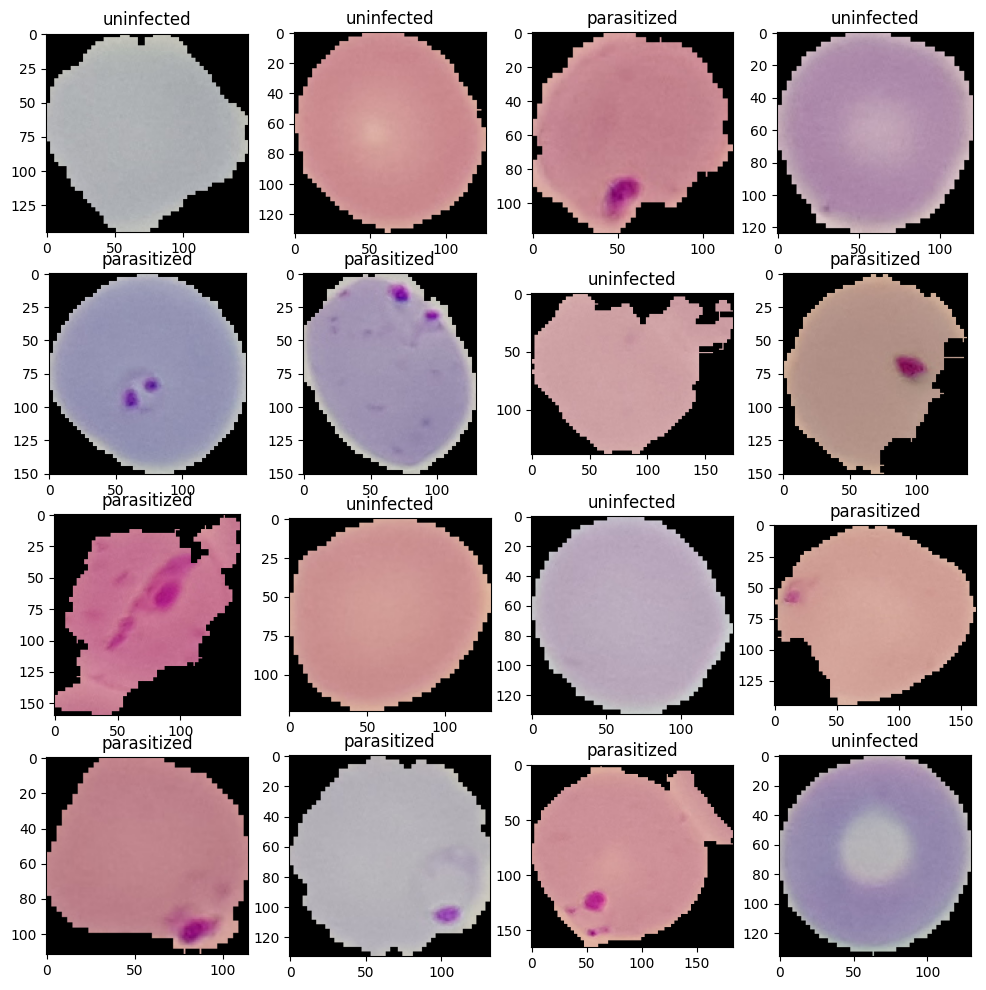

In [8]:
plt.figure(figsize=(12, 12))
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))

In [9]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [10]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [11]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [12]:
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [14]:
model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),
    Dense(100, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid'),

])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [15]:
model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy')

In [28]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = 5, verbose=1)

Epoch 1/5
689/689 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.9556

KeyboardInterrupt: ignored

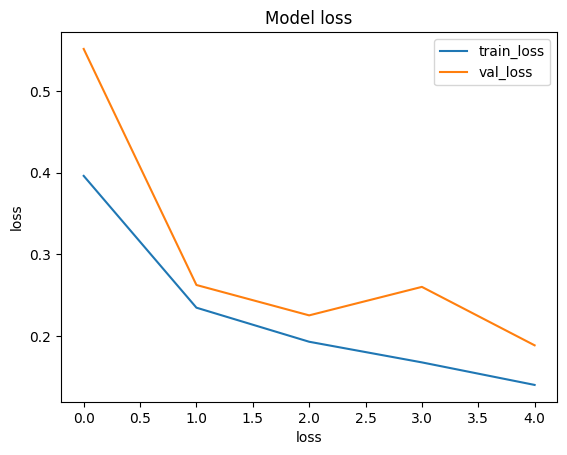

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

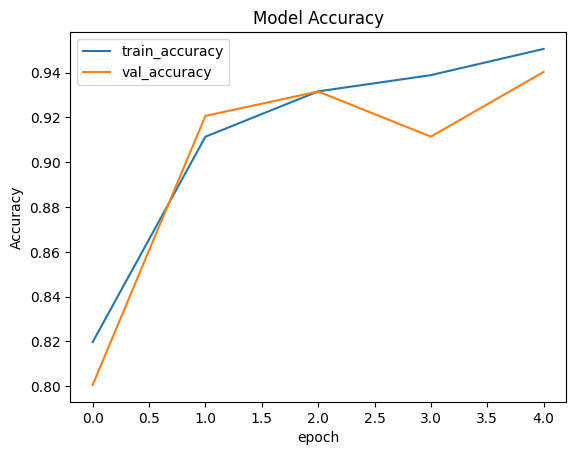

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [19]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [20]:
test_dataset = test_dataset.batch(1)
model.evaluate(test_dataset)

1/1 [==============================] - 12s 12s/step - loss: 0.0020 - accuracy: 1.0000


[0.002044640714302659, 1.0]

In [21]:
def parasite_or_not(x):
    if(x<0.5): return str('Parasite')
    else: return str('Uninfected')

parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 13s 13s/step


'Parasite'

1/1 [==============================] - 0s 113ms/step


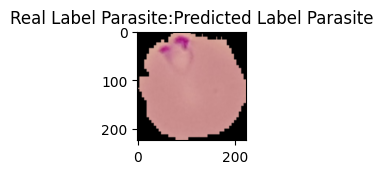

In [22]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    plt.title("Real Label " + str(parasite_or_not(label.numpy()[0])) + ':' + "Predicted Label " + str(parasite_or_not(model.predict(image)[0][0])))

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [27]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input_Image')
x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)

func_model = Model(func_input, func_output, name = 'func_model')
func_model.summary()

Model: "func_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_5 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_6 (Bat  (None, 109, 109, 16)      6

In [36]:
func_model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy')

In [30]:
history = func_model.fit(train_dataset, validation_data=val_dataset, epochs = 5, verbose=1)

Epoch 1/5
689/689 [==============================] - 50s 68ms/step - loss: 0.5571 - accuracy: 0.7126 - val_loss: 0.9977 - val_accuracy: 0.5605
Epoch 2/5
689/689 [==============================] - 46s 67ms/step - loss: 0.2519 - accuracy: 0.9017 - val_loss: 0.2059 - val_accuracy: 0.9347
Epoch 3/5
688/689 [============================>.] - ETA: 0s - loss: 0.2143 - accuracy: 0.9233

KeyboardInterrupt: ignored

In [31]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input_Image')
x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)


features_model = Model(func_input, output, name = 'features_model')
features_model.summary()

Model: "features_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_9 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_10 (Ba  (None, 109, 109, 16)   

In [32]:
x = features_model(func_input)
x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)


full_model = Model(func_input, func_output, name = 'full_model')
full_model.summary()

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 features_model (Functional  (None, 54, 54, 16)        1136      
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_11 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                1

In [33]:
from tensorflow.keras.layers import Layer

In [38]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(FeatureExtractor, self).__init__()

        self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D(pool_size = pool_size, strides=2*strides)

        self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides= strides, padding = padding, activation = activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size = pool_size, strides=2*strides)

    def call(self, x, training):

        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)

        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)

        return x

feature_sub_classed = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)

In [35]:
x = feature_sub_classed(func_input)
x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)


full_model = Model(func_input, func_output, name = 'full_model')
full_model.summary()

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten_3 (Flatten)         (None, 46656)             0         
                                                                 
 dense_9 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_15 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 10)                1

In [40]:
class Full_Model(Model):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
        super(Full_Model, self).__init__()

        self.feature_extractor = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)
        self.flatten = Flatten()
        self.dense_1 = Dense(100, activation = 'relu')
        self.batch_1 = BatchNormalization()

        self.dense_2 = Dense(10, activation = 'relu')
        self.batch_2 = BatchNormalization()

        self.dense_3 = Dense(1, activation = 'sigmoid')

    def call(self, x, training):

        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.dense_2(x)
        x = self.batch_2(x)
        x = self.dense_3(x)
        return x

model_sub_classed = Full_Model(8, 3, 1, 'valid', 'relu', 2)
model_sub_classed(tf.zeros([1, 224, 224, 3]))
model_sub_classed.summary()

Model: "full__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_2 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 dense_12 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_21 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_22 (Ba  multiple                  

In [41]:
model_sub_classed.compile(optimizer = Adam(learning_rate = 0.001),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy')

In [42]:
history = model_sub_classed.fit(train_dataset, validation_data=val_dataset, epochs = 5, verbose=1)

Epoch 1/5
689/689 [==============================] - 60s 83ms/step - loss: 0.4750 - accuracy: 0.7687 - val_loss: 0.5801 - val_accuracy: 0.7659
Epoch 2/5
689/689 [==============================] - 48s 69ms/step - loss: 0.2220 - accuracy: 0.9181 - val_loss: 0.1922 - val_accuracy: 0.9343
Epoch 3/5
689/689 [==============================] - 46s 66ms/step - loss: 0.1733 - accuracy: 0.9396 - val_loss: 0.4517 - val_accuracy: 0.8534
Epoch 4/5
689/689 [==============================] - 46s 67ms/step - loss: 0.1464 - accuracy: 0.9479 - val_loss: 0.1793 - val_accuracy: 0.9396
Epoch 5/5
689/689 [==============================] - 51s 74ms/step - loss: 0.1366 - accuracy: 0.9501 - val_loss: 0.1812 - val_accuracy: 0.9387
